# BART fine-tuning 

**Datasets**:

(1) **ASSET only**
- training: swipe_clean
- validation: asset (randomly selected reference)
- test: swipe (id)

> SARI score: 47.99488613033185

> EASSE SARI score: 39.495948687673675

(2) **Combined**:
- validation: swipe + asset (randomly selected reference) combined
- test: swipe (id)

> SARI score: 47.9358993447983

> EASSE SARI score: **39.6713938379931***

**Settings:**

- warmup steps: 2
- training epochs: 3
- learning rate: 2e-5
- optimizer: adamw_paged8bit

# Load the model

In [1]:
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large', use_fast=True)
model =  BartForConditionalGeneration.from_pretrained('facebook/bart-large', device_map ={'':torch.cuda.current_device()})

# Load the datasets

## Swipe

In [2]:
from datasets import load_from_disk
import pandas as pd

swipe_dataset = load_from_disk("../data/swipe_clean")

In [3]:
from datasets import load_from_disk

tokenized_datasets = load_from_disk("../data/tokenized_swipe_dataset")

In [7]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['r_content', 's_content', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3847
    })
    validation: Dataset({
        features: ['r_content', 's_content', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 479
    })
    test_id: Dataset({
        features: ['r_content', 's_content', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 483
    })
    test_ood: Dataset({
        features: ['r_content', 's_content', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 368
    })
})

## ASSET

In [4]:
from datasets import load_dataset

asset_dataset = load_dataset("facebook/asset", "simplification")

In [5]:
import random

def choose_random_reference(example):
    if len(example['simplifications']) > 0:
        example['simplification'] = random.choice(example['simplifications'])
    return example

asset_dataset['validation'] = asset_dataset['validation'].map(choose_random_reference)
asset_dataset['test'] = asset_dataset['test'].map(choose_random_reference)

In [5]:
def tokenize_func(examples):
    # inputs
    inputs = tokenizer(examples['original'], truncation=True, padding="max_length", max_length=512)
    # labels
    labels = tokenizer(examples['simplification'], truncation=True, padding="max_length", max_length=512)
    # set the labels in the input dictionary
    inputs['labels'] = labels['input_ids']
    return inputs

tokenized_asset_dataset = asset_dataset.map(tokenize_func, batched=True)
tokenized_asset_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

## SwiPE and ASSET Combined

In [6]:
import pandas as pd
from datasets import Dataset

# datasets to pandas DataFrames
swipe_val_df = swipe_dataset['validation'].to_pandas()
asset_val_df = asset_dataset['validation'].to_pandas()

In [7]:
swipe_val_df.head()

,r_content,s_content
0,This is an article about New York City; see al...,New York City is the largest city in the Unite...
1,The Cable News Network (CNN) is an American ba...,The Cable News Network (CNN) is an American ba...
2,"In computing, Epiphany is a web browser for GN...",Epiphany is a web browser for GNOME. It aims t...
3,A paperback (also known as softback or softcov...,A paperback is a type of book. It has a thin c...
4,"In grammar, a phrase is a group of words that ...",A phrase is a small group of words that adds m...


In [9]:
asset_val_df = asset_val_df.rename(columns={'original': 'r_content', 'simplification': 's_content'})
asset_val_df = asset_val_df[['r_content','s_content']]

In [10]:
asset_val_df.head()

,r_content,s_content
0,"Adjacent counties are Marin (to the south), Me...","Nearby counties are Marin (to the south), Mend..."
1,A Georgian inscription around the drum attests...,An inscription around the drum is evidence of ...
2,They would later return to the revived series ...,They returned to the series in the 2008 Christ...
3,"Jameson's autobiography, How to Make Love Like...",Jameson's autobiography was published August 1...
4,It is particularly famous for the cultivation ...,It is really famous for the harvest of kiwifruit.


In [11]:
# combine the datasets
combined_val_df = pd.concat([swipe_val_df, asset_val_df], ignore_index=True)
# shuffle 
shuffled_combined_val_df = combined_val_df.sample(frac=1).reset_index(drop=True)
combined_val_dataset = Dataset.from_pandas(shuffled_combined_val_df)

In [13]:
def tokenize_func(examples):
    # inputs
    inputs = tokenizer(examples['r_content'], truncation=True, padding="max_length", max_length=512)
    # labels
    labels = tokenizer(examples['s_content'], truncation=True, padding="max_length", max_length=512)
    # set the labels in the input dictionary
    inputs['labels'] = labels['input_ids']
    return inputs

tokenized_combined_val_dataset = combined_val_dataset.map(tokenize_func, batched=True)
tokenized_combined_val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/2479 [00:00<?, ? examples/s]

In [14]:
tokenized_combined_val_dataset

Dataset({
    features: ['r_content', 's_content', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2479
})

# Training

In [15]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers.integrations import TensorBoardCallback

training_args = TrainingArguments(
    output_dir="../models/bart-swipe-asset/results-combined",
    eval_strategy="epoch", 
    save_strategy = "epoch", 
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=2e-5, 
    per_device_train_batch_size=6, # 6 -> 4 2 
    per_device_eval_batch_size=6, # 6 -> 4 2
    num_train_epochs=3, # 3 -> 6
    weight_decay=0.01,
    save_total_limit=3, 
    #gradient_accumulation_steps=6, # reduce memory
    load_best_model_at_end=True, # based on valid loss
    warmup_steps = 2,
    optim = "paged_adamw_8bit", # optimizer for quantization
    fp16=True, # enable half-precision
    logging_dir='../models/bart-swipe-asset/logs-combined'
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_combined_val_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# silence warnings
model.config.use_cache = False

In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.183400,0.079890
2,0.265200,0.074399
3,0.130700,0.074672


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warni

TrainOutput(global_step=1926, training_loss=0.6336714172598481, metrics={'train_runtime': 292.6629, 'train_samples_per_second': 39.434, 'train_steps_per_second': 6.581, 'total_flos': 1.2505277106487296e+16, 'train_loss': 0.6336714172598481, 'epoch': 3.0})

# Visualize training process

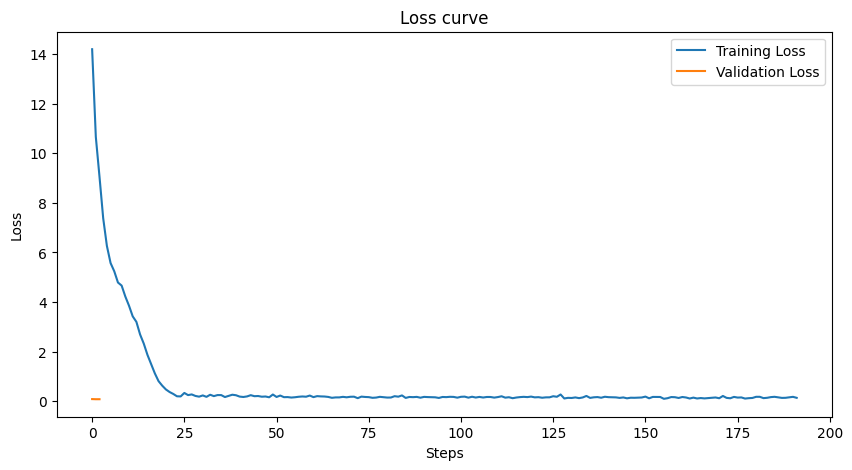

In [17]:
import matplotlib.pyplot as plt

# loss values from the log history
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
steps = range(len(train_loss))

plt.figure(figsize=(10,5))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps[:len(eval_loss)], eval_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.legend()
plt.show()

# Generate predictions

In [18]:
import difflib
from IPython.display import display, HTML

def highlight_diff(sentence1, sentence2):
    diff = difflib.ndiff(sentence1, sentence2)
    highlighted = []
    
    for char in diff:
        if char.startswith('-'):
            highlighted.append(f"<span style='color:red'>{char[2:]}</span>")
        elif char.startswith('+'):
            highlighted.append(f"<span style='color:green'>{char[2:]}</span>")
        else:
            highlighted.append(char[2:])
    
    return ''.join(highlighted)

In [19]:
from transformers import GenerationConfig

generation_config = GenerationConfig(
    bos_token_id = 0,
    decoder_start_token_id = 2,
    eos_token_id = 2,
    early_stopping=True,
    num_beams=4,
    no_repeat_ngram_size=3,
    forced_bos_token_id=0,
    forced_eos_token_id=2,
    pad_token_id = 1
)

model.generation_config = generation_config

In [20]:
example = swipe_dataset['test_id'][1]  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs = tokenizer(example['r_content'], return_tensors="pt", truncation=True, padding="max_length", max_length=512)
inputs = {key: value.to(device) for key, value in inputs.items()}

output_ids = model.generate(
    **inputs, 
    #max_new_tokens = 50,
    max_length=512, 
    min_length=50, 
    length_penalty=1.0, 
)
simplified_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"Original: {example['r_content']}", end='\n\n')
print(f"Simplified: ")
print(simplified_text, end='\n\n')
print(f"Simplified (highlighted): ")
display(HTML(highlight_diff(example['r_content'],simplified_text)))

Original: Russian (Russkij yazyk, Русский язык) is the most widely spoken of the Slavic languages. It is primarily spoken in Russia and other nations of the former Soviet Union, and was also widely taught in schools in member countries of the Warsaw Pact. In Soviet times, Russian was often strongly promoted to the detriment of other local languages. While many of the countries of the former Soviet Union are now promoting their local languages rather than Russian, Russian remains widely spoken in these areas and is often used for intercommunication between these countries. Russian is one of the official languages of the United Nations. Russian is written using the Cyrillic alphabet. Russenorsk is a pidgin language combining Russian and Norwegian. See also: Common phrases in different languages See also: Languages of China --

Simplified: 
Russian (Russkij yazyk, Русский язык) is the most widely spoken of the Slavic languages. It is primarily spoken in Russia and other nations of the for

In [21]:
from tqdm import tqdm

predictions = []
references = []  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for example in tqdm(swipe_dataset['test_id']):
    # tokenize the text
    input_ids = tokenizer(example['r_content'], return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    # move input_ids to the same device as the model
    input_ids = {key: value.to(device) for key, value in input_ids.items()}
    
    # generate prediction
    output_ids = model.generate(**input_ids,max_length = 512, min_length=50, length_penalty=1.0) #max_length=200, min_length=50,
    simplified_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    predictions.append(simplified_text)
    references.append(example['s_content'])

100%|███████████████████████████████████████████| 483/483 [08:26<00:00,  1.05s/it]


In [22]:
df_results = pd.DataFrame({
    'text': swipe_dataset['test_id']['r_content'],
    'reference': swipe_dataset['test_id']['s_content'],
    'prediction': predictions
})

df_results.to_csv("../data/predictions_bart-large-swipe-asset-combined.csv", index=False)
df_results.head()

,text,reference,prediction
0,The term jargon may have the following meaning...,Jargon is a special way to use words that are ...,The term jargon may have the following meaning...
1,"Russian (Russkij yazyk, Русский язык) is the m...",Russian (русский язык (russkij yazyk)) is the ...,"Russian (Russkij yazyk, Русский язык) is the m..."
2,"Great Britain, also called Britain, is an isla...",Great Britain is the main part of the United K...,"Great Britain, also called Britain, is an isla..."
3,"Transport, or transportation (as it is called ...",Transport is the movement of people and things...,"Transport, or transportation (as it is called ..."
4,Stockholm (help·info) (IPA: ['stɔkhɔlm]; UN/LO...,Stockholm is the capital of Sweden. It is loca...,Stockholm (help·info) (IPA: ['stɔkhɔlm]; UN/LO...


# SARI score

In [23]:
from datasets import load_metric
import pandas as pd

sari_metric = load_metric("sari")
sari_scores = []

for index, row in tqdm(df_results.iterrows(), total=len(df_results)):
    r_content = row['text'] 
    s_content = row['reference']  
    prediction = row['prediction']  
    
    sari_score = sari_metric.compute(
        sources=[r_content],
        predictions=[prediction],
        references=[[s_content]] 
    )
    
    sari_scores.append(sari_score['sari'])

/tmp/1097110.1.all.q/ipykernel_2628587/1243258573.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  sari_metric = load_metric("sari")
100%|███████████████████████████████████████████| 483/483 [00:12<00:00, 39.95it/s]


## validation: ASSET only

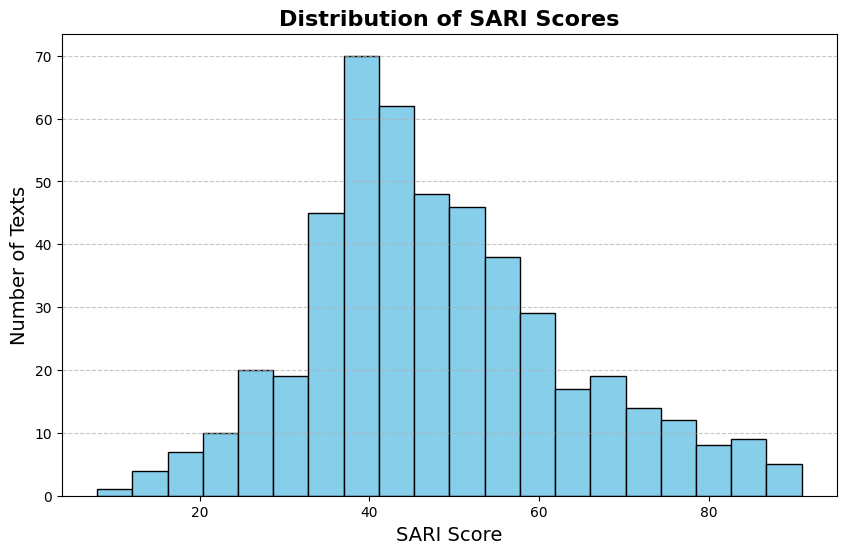

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(sari_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of SARI Scores', fontsize=16, fontweight='bold')
plt.xlabel('SARI Score', fontsize=14)
plt.ylabel('Number of Texts', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [20]:
import numpy as np

print("Overall SARI score: ", np.mean(sari_scores))

Overall SARI score:  47.99488613033185


## Combined

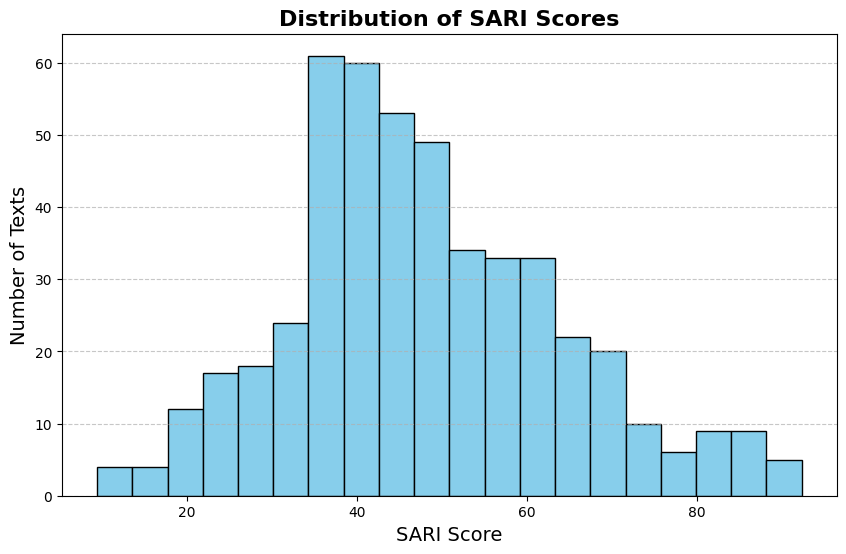

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(sari_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of SARI Scores', fontsize=16, fontweight='bold')
plt.xlabel('SARI Score', fontsize=14)
plt.ylabel('Number of Texts', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [25]:
import numpy as np

print("Overall SARI score: ", np.mean(sari_scores))

Overall SARI score:  47.9358993447983


# EASSE SARI

In [26]:
import sys,os
sys.path.append('../easse')

from easse.sari import corpus_sari


sari_scores_easse = []

for index, row in tqdm(df_results.iterrows(), total=len(df_results)):
    r_content = row['text'] 
    s_content = row['reference']  
    prediction = row['prediction']  
    
    sari_score = corpus_sari(
        orig_sents=[r_content],
        sys_sents=[prediction],
        refs_sents=[[s_content]] 
    )
    
    sari_scores_easse.append(sari_score)

100%|██████████████████████████████████████████| 483/483 [00:00<00:00, 535.57it/s]


## Validation: ASSET only

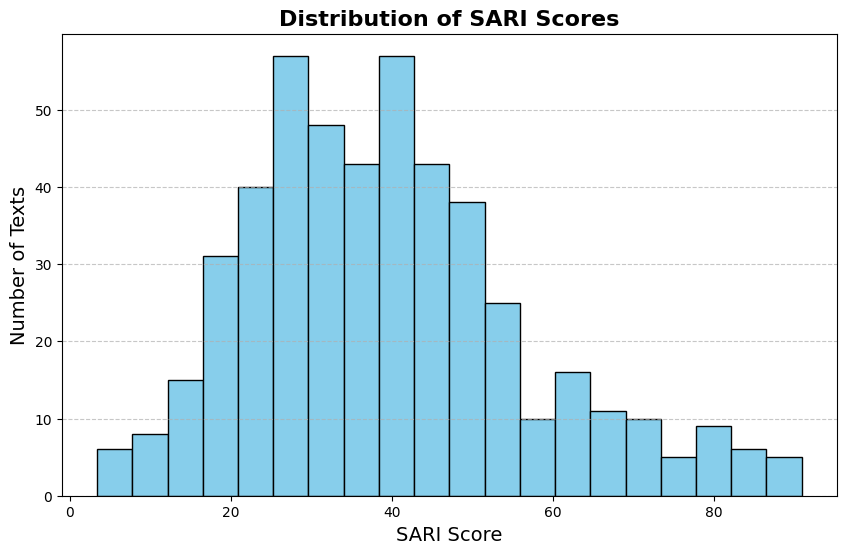

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(sari_scores_easse, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of SARI Scores', fontsize=16, fontweight='bold')
plt.xlabel('SARI Score', fontsize=14)
plt.ylabel('Number of Texts', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [23]:
import numpy as np

print("Overall SARI score: ", np.mean(sari_scores_easse))

Overall SARI score:  39.495948687673675


## Combined

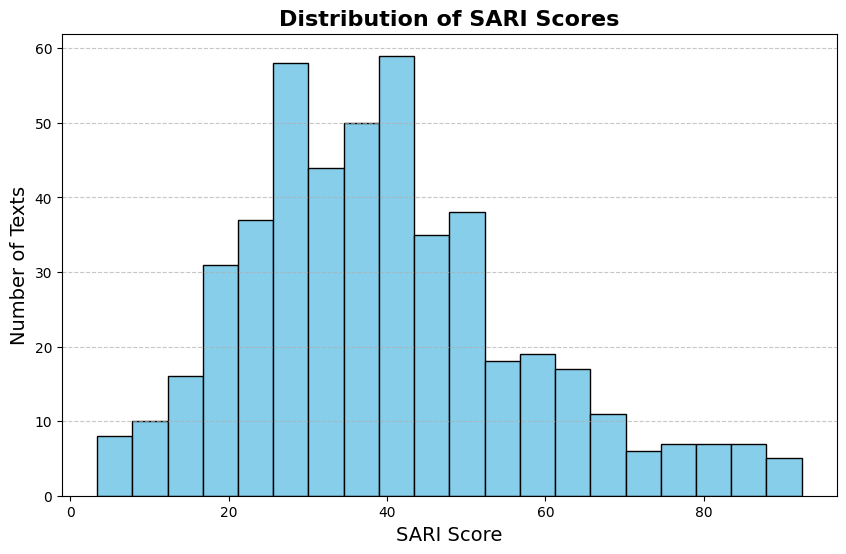

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(sari_scores_easse, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of SARI Scores', fontsize=16, fontweight='bold')
plt.xlabel('SARI Score', fontsize=14)
plt.ylabel('Number of Texts', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [28]:
import numpy as np

print("Overall SARI score: ", np.mean(sari_scores_easse))

Overall SARI score:  39.6713938379931


# Save model

In [24]:
#generation_config.save_pretrained("../models/bart-swipe/model")
#model.save_pretrained("../models/bart-swipe/model")